# First Study of Data
In this step, we join both train and test set, without any previous action, to study the data.

In [1]:
import numpy as np
import pandas as pd

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

## Importing datasets

In [30]:
train = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")
df = pd.concat([train,test],axis=0)

In [3]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


## Checking and visualizing missing info

In [31]:
train.info()
print("-"*50)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         41

There are some missing information regarding age in both train and test set. We can imputate this info as it's not a large quantity.<br>
There is one missing information regarding fare in the test set and two missing information regarding embarked in the train set. We can imputate this info too.<br>
There are a lot of missing information regarding cabin in both train and test set. We cannot imputate any data here.

Text(0.5, 1.0, 'Missing data for each column')

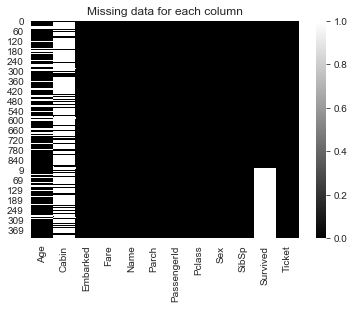

In [32]:
sns.heatmap(df.isnull(),cmap="binary_r")
plt.title("Missing data for each column")

## Imputating Data
In order to imputate data, we'll keep using both sets together in order to avoid adding too much noise.
### Imputate Age
Let's start imputating the age values. First, let's check age distribution.

Text(0.5, 1.0, 'Distribution of Age')

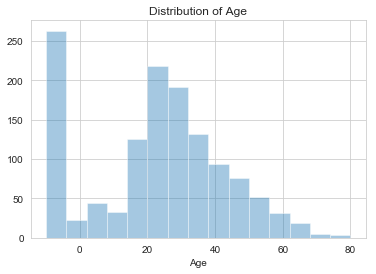

In [34]:
sns.distplot(df["Age"].fillna(-10),kde=False,bins=15)
plt.title("Distribution of Age")

From the above plot, we can see that there is a concentration around 25 years old. We could just fill all the missing values with the median or the mean. But I think we can do better!

Text(0.5, 1.0, 'Age distribution by Sex')

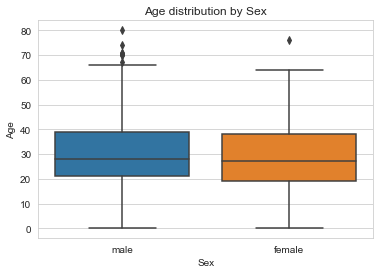

In [36]:
sns.boxplot(x="Sex",y="Age",data=df)
plt.title("Age distribution by Sex")

We can see that the average man aboard was slightly older than the average woman. Let's go further and investigate separating by Pclass (passenger class)

Text(0.5, 1.0, 'Age distribution by Pclass separated by Sex')

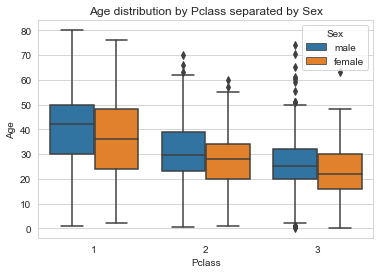

In [23]:
sns.boxplot(x="Pclass",y="Age",data=df,hue="Sex")
plt.title("Age distribution by Pclass separated by Sex")

The boxplot above shows that, for higher classes, people tended to be older. This makes sense as older people have had more time to accumulate wealthiness, whereas younger people have to save money. We will imputate age with the medians for each pclass/sex combo.

In [37]:
def imputate_age(person):
    age = person[0]
    if pd.isnull(age):
        sex = person[1]
        pclass = person[2]
        if pclass == 1:
            if sex == "male":
                return 42
            else:
                return 35
        elif pclass == 2:
            if sex == "male":
                return 30
            else:
                return 28
        else:
            if sex == "male":
                return 25
            else:
                return 22
    return age

df["Age"] = df[["Age","Sex","Pclass"]].apply(imputate_age,axis=1)

# Check if all missing info is filled
print("Missing age values: {}".format(df["Age"].isnull().sum()))

Missing age values: 0


Text(0.5, 1.0, 'Distribution of Ages after data imputation')

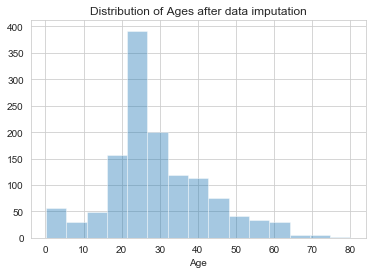

In [38]:
sns.distplot(df["Age"],kde=False,bins=15)
plt.title("Distribution of Ages after data imputation")

### Imputate Fare

In [39]:
df[df["Fare"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


Our passenger with missing Fare info is from Pclass = 3. I'm not sure if filtering further by Embarked will help. Let's try both.

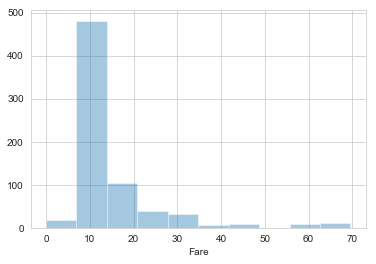

In [43]:
sns.distplot(df.loc[df["Pclass"] == 3,"Fare"].dropna(),kde=False,bins=10)

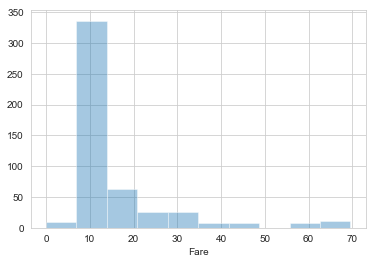

In [44]:
sns.distplot(df.loc[(df["Pclass"] == 3) & (df["Embarked"] == "S"),"Fare"].dropna(),kde=False,bins=10)

The trend is the same for both sets.

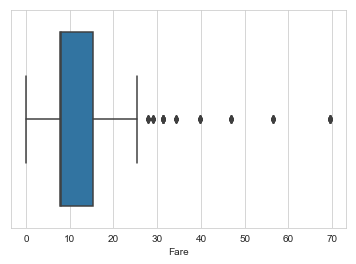

In [45]:
sns.boxplot(df.loc[df["Pclass"]==3,"Fare"].dropna())

Let's use the median value for filling data as there are lots of outliers

In [52]:
print("3rd class fare:")
print("Mean: {:4f}".format(df.loc[df["Pclass"]==3,"Fare"].mean()))
print("Median: {:4f}".format(df.loc[df["Pclass"]==3,"Fare"].median()))
df["Fare"].fillna(df.loc[df["Pclass"]==3,"Fare"].median(),inplace=True)
print("-"*25)
print("Missing fare values: {}".format(df["Fare"].isnull().sum()))

3rd class fare:
Mean: 13.295480
Median: 8.050000
-------------------------
Missing fare values: 0


### Imputate Embarked

In [53]:
df[df["Embarked"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


These two women were in the sabe Cabin and shared the same ticket. I couldn't help myself but searching their relationship. Turns out Mrs. George was a widow and travelled with her maid, Miss Icard. They both Embarked in Southampton (S). In the majority of problems, researchs like this may not be possible/allowed, so let's confirm the data as we didn't know it!

Text(0.5, 1.0, 'Number of People Embarked in each Port')

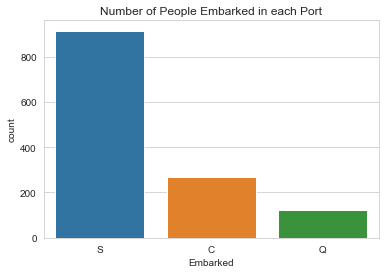

In [55]:
sns.countplot(df["Embarked"])
plt.title("Number of People Embarked in each Port")

Text(0.5, 1.0, 'People Embark Port by Pclass')

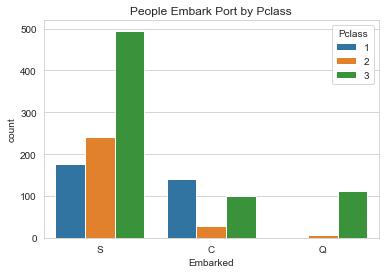

In [57]:
sns.countplot(x="Embarked",data=df,hue="Pclass")
plt.title("People Embark Port by Pclass")

From the previous plot, we see that most people embarked in Southampton (S).<br>
This new plot shows that there is almost a tie between 1st class people embarking in S and in C, with an advantage for S. So, our prediction confirms the reality! Let's fill this up.

In [58]:
df["Embarked"].fillna("S",inplace=True)
print("Missing embarked values: {}".format(df["Embarked"].isnull().sum()))

Missing embarked values: 0


### Checking for any additional missing values

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 172.9+ KB


There are only Cabin values missing and we'll not imputate anything there. Survived has only 891 values as it is the size of the training set. The test set does not contain this info, because it is our job to predict it.<br>
Let's now save the clean datasets to files.

In [60]:
train = df[:891]
test = df[891:]

In [61]:
train.head(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282


We can see that in our concatenation, **Survived** column became float. Let's fix it

In [62]:
train["Survived"] = train["Survived"].apply(int)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
train.head(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282


In [64]:
test.head(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,NaN,330911
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,NaN,363272
2,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,NaN,240276


In [65]:
train.to_csv('cleantrain.csv',index=False)
test.to_csv('cleantest.csv',index=False)